# Osteoarthritis Knee X-ray

We are given google drive link in the 'Data' section of problem page which has all the required train images (to build the model) and test images to predict the label of these images and submit the predictions on the DPhi platform.

## Importing libraries

In [1]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from google_drive_downloader import GoogleDriveDownloader as gdd
import seaborn as sns

## Downloading the image dataset

We can use GoogleDriveDownloader form google_drive_downloader library in Python to download the shared files from the shared Google drive link: https://drive.google.com/file/d/1NdDqPK4NLn2aV8ZdF5ilux1sfG6IyebC/view?usp=sharing

The file id in the above link is: 1NdDqPK4NLn2aV8ZdF5ilux1sfG6IyebC

In [2]:
# gdd.download_file_from_google_drive(file_id='1NdDqPK4NLn2aV8ZdF5ilux1sfG6IyebC',
# dest_path='content/KneeXray.zip',
# unzip=True)

### Loading the training dataset

In [2]:
train_data = pd.read_csv('content/KneeXray/Train.csv')
train_data.head()

,filename,label
0,Image_1.jpg,0
1,Image_2.jpg,1
2,Image_3.jpg,0
3,Image_4.jpg,1
4,Image_5.jpg,2


In [3]:
train_data.shape

(7828, 2)

### Creating train dataframe

In [5]:
image_paths = ["content/KneeXray/train/" + str(file) for file in train_data.filename]

In [6]:
train_data['filePaths'] = image_paths
train_data.head()

,filename,label,filePaths
0,Image_1.jpg,0,content/KneeXray/train/Image_1.jpg
1,Image_2.jpg,1,content/KneeXray/train/Image_2.jpg
2,Image_3.jpg,0,content/KneeXray/train/Image_3.jpg
3,Image_4.jpg,1,content/KneeXray/train/Image_4.jpg
4,Image_5.jpg,2,content/KneeXray/train/Image_5.jpg


### Loading training images

#### Loading a sample image

In [7]:
import random 
import cv2

i = random.randint(0, len(train_data))

sample_img = cv2.imread(train_data.iloc[i, 2], 0)

Text(0.5, 0, '(224, 224)')

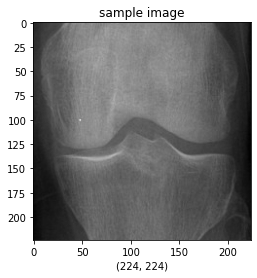

In [8]:
plt.imshow(sample_img, cmap='gray')
plt.title("sample image")
plt.xlabel(sample_img.shape)

In [9]:
input_shape = sample_img.shape
input_shape

(224, 224)

All Images are of the same size 224*224

In [10]:
import cv2

train_images = []

for filepath in train_data.filePaths:
    img = cv2.imread(filepath, 0)
    train_images.append(img)

train_images = np.array(train_images)

In [12]:
train_images.dtype

dtype('uint8')

### Viewing a sample lot

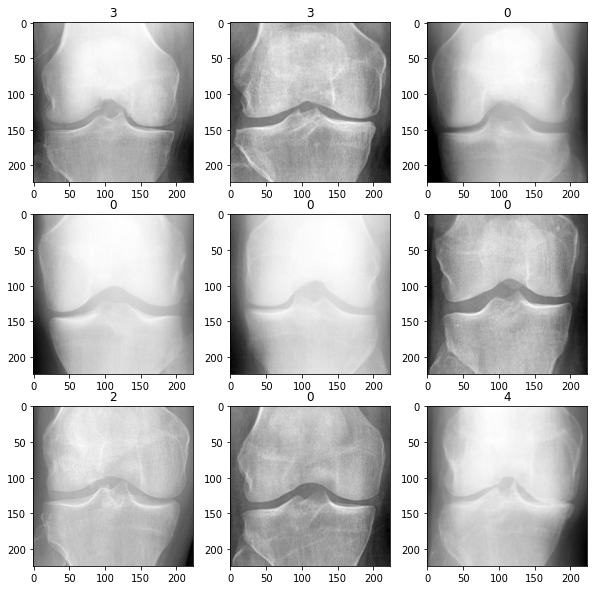

In [13]:
plt.figure(figsize=(10, 10))
for i in range(9):
    index = random.randint(0, len(train_images))
    label = train_data.iloc[index, 1]
    plt.subplot(3, 3, i+1)
    plt.imshow(train_images[index], cmap='gray')
    plt.title(label)

## Preprocessing the images

### Scaling the images

In [14]:
train_images = train_images / 255.0

In [14]:
train_images.dtype

dtype('float64')

In [15]:
train_images = np.array(train_images, dtype=np.float16)

### Resizing the images

In [16]:
train_images = train_images.reshape(train_images.shape[0], 224, 224, 1)
train_images.shape

(7828, 224, 224, 1)

## Building the model

### Defining model structure

-  Convolutional layers
1. Layer 1 Convolution - 32- (3, 3) relu
2. Layer 2 Maxpooling - (2, 2)
3. Layer 3 Convolution - 16- (3, 3) relu
4. Layer 4 Maxpooling - (2, 2)

- Fully Connected Layers
5. Layer 5 Flatten
6. Layer 6 Dense 256 relu
7. Layer 7 Dropout layer 0.3
8. Layer 8 Dense 128 relu
9. Layer 9 Dropout layer 0.3
10. Layer 10 Dense 5 output softmax

In [34]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten

model = Sequential()

# model.add(Conv2D(64, (3, 3), padding='valid', activation='relu', input_shape=(224, 224, 1)))
# model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='valid', activation='relu', input_shape=(224, 224, 1)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(16, (3, 3), padding='valid', activation='relu', input_shape=(224, 224, 1)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(5, activation='softmax'))

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 222, 222, 32)      320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 109, 109, 16)      4624      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 54, 54, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 46656)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               11944192  
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)              

### Compiling the model

- loss function : sparse categorical cross entropy
- Optimizer : Adam
- learning rate : 0.001
- metric : accuracy

In [37]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

### Fitting the data

#### Splitting the data into training and testing

In [38]:
X = train_images
y = train_data.label

In [39]:
X.shape, y.shape

((7828, 224, 224, 1), (7828,))

In [40]:
y  = pd.get_dummies(y)
y

,0,1,2,3,4
0,1,0,0,0,0
1,0,1,0,0,0
2,1,0,0,0,0
3,0,1,0,0,0
4,0,0,1,0,0
...,...,...,...,...,...
7823,1,0,0,0,0
7824,0,0,0,0,1
7825,1,0,0,0,0
7826,0,0,1,0,0


In [41]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y)

In [44]:
x_test.shape, x_train.shape

((1957, 224, 224, 1), (5871, 224, 224, 1))

In [45]:
y_test.shape, y_train.shape

((1957, 5), (5871, 5))

#### Defining callbacks

In [42]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, mode='min')

In [43]:
ep = 100
bs = 16

model.fit(x=x_train, y=y_train, epochs=ep, callbacks=[es], verbose=1, validation_split=0.2)

Epoch 1/100


InvalidArgumentError:  logits and labels must have the same first dimension, got logits shape [32,5] and labels shape [160]
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at C:\Users\phadk\AppData\Local\Temp/ipykernel_2044/1371621650.py:4) ]] [Op:__inference_train_function_19711]

Function call stack:
train_function


dtype('float16')